In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[nltk_data] Downloading package punkt to /home/labsuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/labsuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/labsuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
# Description of the dataset
print('SHAPE OF DATASET: ')
print(df.shape)
print(df.columns)
print(df.category.unique())

SHAPE OF DATASET: 
(2225, 2)
Index(['category', 'text'], dtype='object')
['tech' 'business' 'sport' 'entertainment' 'politics']


NUMBER OF SAMPLES IN EACH CATEGORY: 



<AxesSubplot:xlabel='category', ylabel='count'>

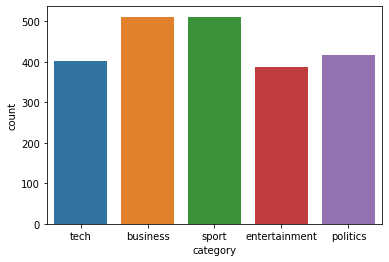

In [4]:

# Plotting number of samples within each category
print('NUMBER OF SAMPLES IN EACH CATEGORY: \n')
sns.countplot(df.category)

In [5]:
# DATA CLEANING
print('Data cleaning in progress...')

# Tokenize
df['text_clean'] = df['text'].apply(nltk.word_tokenize)
print('Tokenization complete.')

Data cleaning in progress...
Tokenization complete.


In [6]:
# Remove stop words
stop_words=set(nltk.corpus.stopwords.words("english"))
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
print('Stop words removed.')


Stop words removed.


In [7]:
# Remove numbers, punctuation and special characters (only keep words)
regex = '[a-z]+'
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
print('Numbers, punctuation and special characters removed.')


Numbers, punctuation and special characters removed.


In [8]:
# Lemmatization
lem = nltk.stem.wordnet.WordNetLemmatizer()
df['text_clean'] = df['text_clean'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
print('Lemmatization complete.\nData cleaning complete.')

Lemmatization complete.
Data cleaning complete.


In [13]:

# Classification using word2vec vectorizer

vec_model = Word2Vec(df['text_clean'])
w2v = dict(zip(vec_model.wv.index2word, vec_model.wv.syn0))

class Vectorizer(object):
    
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])

class Classifier(object):
    
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gs = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)        

    def fit(self, X, y):        
        return self.gs.fit(X, y)

    def predict(self, X):
        return self.gs.predict(X)

clf_models = {
    'Naive Bayes': GaussianNB(), 
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),  
    'Perceptron': MLPClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

clf_params = {
    'Naive Bayes': { }, 
    'SVC': { 'kernel': ['linear', 'rbf'] },
    'Decision Tree': { 'min_samples_split': [2, 5] }, 
    'Perceptron': { 'activation': ['tanh', 'relu'] },
    'Gradient Boosting': { 'min_samples_split': [2, 5] }
}

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, shuffle=True)

for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec vectorizer', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(key, ':')
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
     

Naive Bayes :
Accuracy: 0.366 	Precision: 0.379 	Recall: 0.344 		F1: 0.339

SVC :
Accuracy: 0.326 	Precision: 0.134 	Recall: 0.277 		F1: 0.179

Decision Tree :
Accuracy: 0.335 	Precision: 0.340 	Recall: 0.332 		F1: 0.334

Perceptron :
Accuracy: 0.326 	Precision: 0.136 	Recall: 0.279 		F1: 0.179

Gradient Boosting :
Accuracy: 0.420 	Precision: 0.407 	Recall: 0.411 		F1: 0.405



In [ ]:
# Classification using TFIDF vectorizer

# Vectorize training and testing data
def Vectorize(vec, X_train, X_test):    
    
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    
    print('Vectorization complete.\n')
    
    return X_train_vec, X_test_vec

# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train, X_test, y_train, y_test):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        print("Precision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    
    return

models = {
    'Naive Bayes': MultinomialNB(), 
    'Decision Tree': DecisionTreeClassifier(),  
    'Perceptron': MLPClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] }, 
    'Decision Tree': { 'min_samples_split': [1, 2, 5] }, 
    'Perceptron': { 'alpha': [0.0001, 0.001], 'activation': ['tanh', 'relu'] },
    'Gradient Boosting': { 'learning_rate': [0.05, 0.1], 'min_samples_split': [2, 5] }
}

# Encode label categories to numbers
enc = LabelEncoder()
df['category'] = enc.fit_transform(df['category'])
labels = list(enc.classes_)

# Train-test split and vectorize
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, shuffle=True)
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(), X_train, X_test)

ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)

Vectorization complete.

Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Precision: 0.962 	Recall: 0.960 		F1: 0.960

Decision Tree : {'min_samples_split': 2}
Precision: 0.797 	Recall: 0.789 		F1: 0.792

Perceptron : {'activation': 'tanh', 'alpha': 0.001}
Precision: 0.976 	Recall: 0.975 		F1: 0.975

